# Simple 4 layer model

**For this notebook, a simple 4 layer model is used to create synthetic data. The data are Gamma Ray, Induction, Neutron-Density and Photoelectric effect. The orientation of the layers is horizontal.**

In [1]:
import numpy as np
import pandas as pd
import importlib
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats
import seaborn as sns
import gempy as gp

import sys
sys.path.append("../")
import bayseg

C:\Users\Public\Anaconda3\lib\site-packages\gempy\posterior_analysis.py:24: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")


In [2]:
# data import
data = pd.read_csv("../data/synthetic_data_2.csv")                         # load the data from excel sheet
data.head()        

,X,Y,Z,Well Name,GR,NEUDEN,IND,PE
0,50,50,10,BH1,0.00,0.00,0.00,0.00
1,50,50,20,BH1,0.00,0.00,0.00,0.00
2,50,50,30,BH1,0.00,0.00,0.00,0.00
3,50,50,40,BH1,50.66,3.45,11.22,0.28
4,50,50,50,BH1,52.84,3.72,11.57,0.09


In [3]:
# data setting
feature_names =  ['GR', 'NEUDEN', 'IND','PE']    # define data that are considered by headers from excel sheet(Gamma Ray,Induction, Neutron-density, delta Neutron-density, Photoelectric effect)
feature_vectors = data[feature_names]                             # create matrix including the data + headers
coords = np.array(data["Z"].values).T                       # creating vector with depth information (z in [m])

In [4]:
feature_vectors_norm = bayseg.normalize_feature_vectors(feature_vectors.values) # normalize data (.values just takes the values not the header and indicies)

In [5]:
# Bayesian information criteria
nf = bayseg.test_bic(feature_vectors_norm)

The optimal number of layers is:  5


In [6]:
# perform BaySeg clustering
clf = bayseg.BaySeg(feature_vectors_norm, nf)

clf.fit(10, # number of iterations
        beta_jump_length=2, 
        mu_jump_length=0.0005, 
        cov_volume_jump_length=0.00005, 
        theta_jump_length=0.0000005, verbose=False)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:01<00:00,  5.82it/s]


In [7]:
# data convertion to gempy
bayseg.prepare_gempy_input(data,clf.labels[-1]+1)

# Gempy

In [12]:
# Importing the data from CSV-files and setting extent and resolution
geo_data = gp.create_data([0,200,0,200,0,200],[50,50,50], 
                          path_o = "../data/Gempy_Simple_4_layer_90degrees_orientation.csv", # importing orientation (foliation) data
                          path_i = "../data/Gempy_Simple_4_layer_90degrees.csv") # importing point-positional interface data

In [13]:
## force formations to be strings
#geo_data.interfaces['formation'] = geo_data.interfaces['formation'].astype(str)
#geo_data.orientations['formation'] = geo_data.orientations['formation'].astype(str)

In [14]:
gp.plot_data_3D(geo_data)

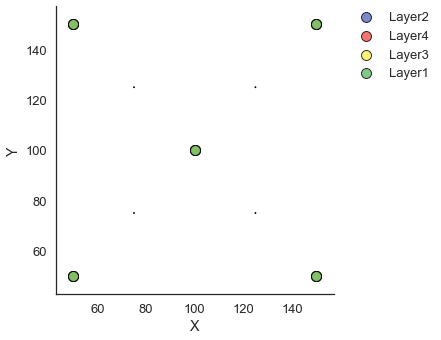

In [12]:
gp.plot_data(geo_data, direction='z')

In [15]:
# Assigning series to formations as well as their order (timewise)
gp.set_series(geo_data, {"Unknown": ('Layer5','Layer4','Layer2', 'Layer3', 'Layer1')},
                       order_series = ["Strat_Series"],
                       order_formations=['Layer5','Layer4','Layer2', 'Layer3', 'Layer1'], verbose=0) 

In [16]:
#gp.get_data(geo_data, verbosity=1)

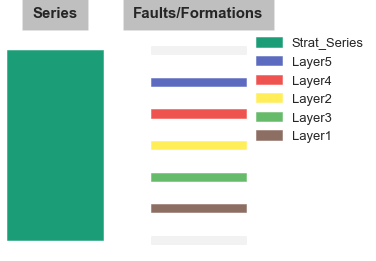

In [17]:
gp.get_sequential_pile(geo_data)

In [ ]:
# u_grade depends on number of series (one series [1], two series [1,1]...) 
interp_data = gp.InterpolatorData(geo_data, u_grade=[1], output='geology', compile_theano=True,
                                  dtype='float64', theano_optimizer='fast_compile')

Compiling theano function...


In [ ]:
#interp_data.geo_data_res.get_formation_number()

In [ ]:
gp.get_kriging_parameters(interp_data)

In [ ]:
#interp_data.update_interpolator(geo_data)

In [ ]:
lith_block, fault_block = gp.compute_model(interp_data)

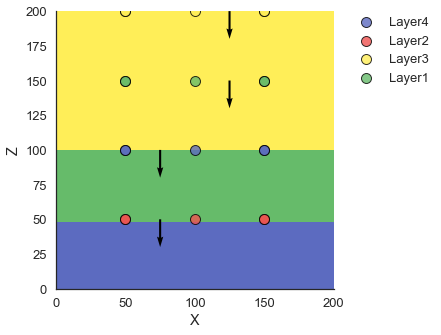

In [21]:
gp.plot_section(geo_data, lith_block[0], cell_number=10,  direction='y', plot_data=True)

In [22]:
#gp.plot_scalar_field(geo_data, lith_block[1], 15)
#plt.colorbar()

In [23]:
#interp_data.potential_at_interfaces

In [24]:
ver, sim = gp.get_surfaces(interp_data, lith_block[1], original_scale=True)

Potential field of the surface is outside the block. Probably is due to float errors


In [25]:
gp.plot_surfaces_3D(geo_data, ver, sim, alpha=1)